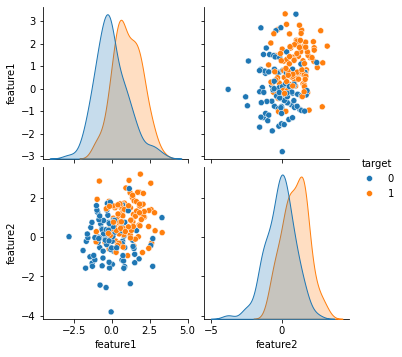

In [44]:
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix, auc
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
sys.path.insert(0, '../Code/')

pos_label = 1
neg_label = 0

def plt_roc_threshold(vainilla_model, tuned_model, X_test, y_test, scorings, pos_label=1):
    decision_threshold = getattr(tuned_model, "best_threshold_", 0.5)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    
    RocCurveDisplay.from_estimator(
        vainilla_model,
        X_test,
        y_test,
        pos_label=pos_label,
        #linestyle=linestyle,
        #color=color,
        ax=ax,
        #name=name,
        plot_chance_level=True,
    )

    ax.plot(
        scorings["fpr_score"](vainilla_model, X_test, y_test),
        scorings["tpr_score"](vainilla_model, X_test, y_test),
        marker="o",
        markersize=10,
        color="tab:blue",
        label="Default cut-off point at a probability of {:.2f}".format(0.5),
    )

    ax.plot(
        scorings["fpr_score"](tuned_model, X_test, y_test),
        scorings["tpr_score"](tuned_model, X_test, y_test),
        marker="o",
        markersize=10,
        color="tab:red",
        label="Default cut-off point at a probability of {:.2f}".format(decision_threshold),
    )

    ax.legend()
    plt.title("ROC")
    plt.show()


def fpr_score(y_true, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y_true, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr
tpr_score = recall_score


scorings = {
    "fpr_score": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr_score": make_scorer(tpr_score, pos_label=pos_label), 
}

# Generar un dataset artificial de clasificación binaria
X, y = make_blobs(n_samples=200, n_features=2, centers=[(0,0), (1,1)], cluster_std=1.0, center_box=(-10.0, 10.0), shuffle=True, random_state=50, return_centers=False)

df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['target'] = y 
sns.pairplot(df, hue='target')
   

In [45]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [1, 2, 3, 4, 5]}, cv=5)
model.fit(X_train, y_train)
print(model.best_params_)

{'n_neighbors': 4}


In [46]:
pp = model.predict_proba(X_test)
ppdf = pd.DataFrame(pp, columns=['PC0', 'PC1'])
ppdf['target'] = y_test
ppdf.sort_values(by='PC1', ascending=False, inplace=True)
ppdf['cumulative'] = ppdf['target'].cumsum()


Agregamos un nuevo scoring

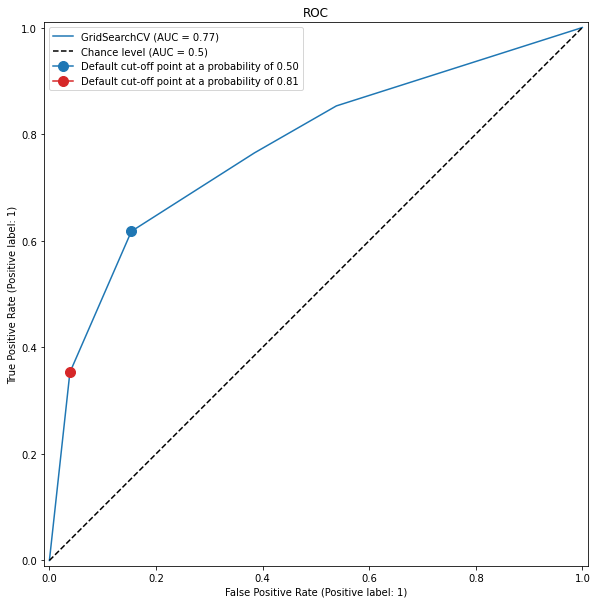

In [47]:
def gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    rotated_cm = np.rot90(cm,2)
    #Para que la matriz de confusión sea como figura en los textos
    gain_matrix = np.array(
        [
            [-100, -3],  
            [-1,    0],  # 
        ]
    )
    return np.sum(rotated_cm * gain_matrix)

scorings["cost_gain"] = make_scorer(
    gain_score, neg_label=neg_label, pos_label=pos_label
)
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=scorings["cost_gain"], # accuracy 
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
plt_roc_threshold(model, tuned_model, X_test, y_test, scorings, pos_label=pos_label)